# Ch6 lab: Linear model selection and regularisation

### 1. Libraries

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd 
import math
import random
import itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import *
from sklearn import datasets, linear_model
from sklearn.decomposition import PCA 
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.preprocessing import StandardScaler, scale 
from sklearn import linear_model 
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler # had to add this in order to normalise the ridge regression model

### 2. Best subset selection 

Best subset selection is a technique to identify the most relevant features or variables that should be included in a predictive model. It involves systematically evaluating all possible combinations of features and selecting the subset that yields the best model performance.

<b>Best subset selection may be a better choice of feature selection method than others (forward / backward selection, regularisation methods) in the following circumstances:</b>
- When interpretability is crucial: Best subset selection allows you to identify the most relevant features, resulting in a concise and interpretable model. If interpretability is a priority, and computational resources are sufficient, best subset selection can provide valuable insights.
- When computational resources are available: Evaluating all possible feature combinations can be computationally expensive, especially with a large number of features. Best subset selection requires exhaustive evaluation, so it is feasible when you have sufficient computational resources to handle the computational burden.

To start we will set the maximum number of features to 3 so that we restrict the subset selection process to consider only up to 3 features per model. The code will then iterate through all possible subsets of 1, 2, and 3 features, evaluating the performance of the models using these subsets. The subset that produces the best performance among these limited choices will then be selected.

In [3]:
# creating a function that limits the number of features to be selected during the subset selection process
max_feature = 3 

In [8]:
# reading in the data and taking a look at the data
hitters = pd.read_csv('data/Hitters.csv', header = 0, na_values = 'NA')

In [9]:
print(list(hitters)) # geting the header of this data

['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague']


In [11]:
print(hitters.shape) # geting the dimension of this dataset

(322, 20)


In [12]:
hitters.head() # pulling a sample of this dataset

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [20]:
# cleaning the data to remove NAs, starting by seeing no. NA's in dataset (I can see at least one in Salary column but there may be more)
print(hitters.isnull().sum())

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64


In [25]:
# dropping NAs
hitters = hitters.dropna().reset_index(drop=True) # drop the observation with NA values and reindexing the dataframe so that rows form is the same as before

In [23]:
# checking dataset post dropping NA columns
print(hitters.shape)
print(hitters['Salary'].isnull().sum())

(263, 20)
0


In [29]:
# feature engineering to prepare data for modelling
y = hitters.Salary # defining response variable 
dummies = pd.get_dummies(hitters[['League', 'Division', 'NewLeague']]) # creating dummy variables for the columns with categorical variables
print(dummies.head()) # checking dummy rows
X_prep = hitters.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64') # creates new dataframe, dropping the old columns with categorical variables and the response
X = pd.concat([X_prep, dummies[['League_A', 'Division_E', 'NewLeague_A']]], axis=1) # adding the columns with dummy variables to new dataframe

# other notes
# 'axis=1' specifies that the operation is performed on columns
# 'astype('float64')' converts dataframe into a float data type 

   League_A  League_N  Division_E  Division_W  NewLeague_A  NewLeague_N
0         0         1           0           1            0            1
1         1         0           0           1            1            0
2         0         1           1           0            0            1
3         0         1           1           0            0            1
4         1         0           0           1            1            0


In [30]:
# defining functions to be ready for best subset selection 

def getRSS(y, X, feature_list):
    model = sm.OLS(y, X[list(feature_list)]).fit()
    RSS = ((model.predict(X[list(feature_list)]) - y) ** 2).sum()
    return {'Model':model, "RSS":RSS}

# function above returns a dictionary containing the fitted model object and the residual sum of squares for that model

def bestModel(y, X, K):
    results = []
    for c in itertools.combinations(X.columns, K):
        results.append(getRSS(y, X, c))     
    model_all =  pd.DataFrame(results)
    best_model = model_all.loc[model_all["RSS"].idxmin()]
    return best_model

# function above performs best subset selection by iterating over all possible combinations of features of size K from the feature matrix X
# The results are stored in a list of dictionaries (results)
# Finally, it creates a DataFrame (model_all) from the list of results and returns the model with the lowest RSS

<b>Note: alternative way to do the same as above:</b>

<code>from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np </code>

<b>Create a linear regression model object</b>
<code>model = LinearRegression()</code>

<b>Define the parameter grid for GridSearchCV</b>
<code>param_grid = {</code>
    <code>'fit_intercept': [True, False],</code>
    <code>'normalize': [True, False]</code>
<code>}</code>


<b>Create the GridSearchCV object</b>
<code> grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5) </code>

<b>Fit the GridSearchCV object to the data</b>
<code> grid_search.fit(X, y)</code>

<b>Get the best model</b>
<code>best_model = grid_search.best_estimator_</code>


In [32]:
# performing best model selection

models = pd.DataFrame(columns=["RSS", "Model"]) # initialises an empty pandas DataFrame called models with two columns: "RSS" and "Model". This df will store RSS and model objects for different feature subsets 
for i in range(1,(max_feature+1)): # enters a loop that iterates from 1 to max_feature+1 (inclusive). This loop represents the number of features to consider in each iteration
    models.loc[i] = bestModel(y, X, i) # inside loop, 'bestModel' function is called with the target variable y, feature matrix X, and the current number of features i. Then added to the 'models' DataFrame using the loc function, with i as the row index
    
print(models.loc[2, 'Model'].summary()) #  prints the summary of the model with 2 features stored in the models DataFrame

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.761
Model:                            OLS   Adj. R-squared (uncentered):              0.760
Method:                 Least Squares   F-statistic:                              416.7
Date:                Tue, 23 May 2023   Prob (F-statistic):                    5.80e-82
Time:                        11:00:47   Log-Likelihood:                         -1907.6
No. Observations:                 263   AIC:                                      3819.
Df Residuals:                     261   BIC:                                      3826.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

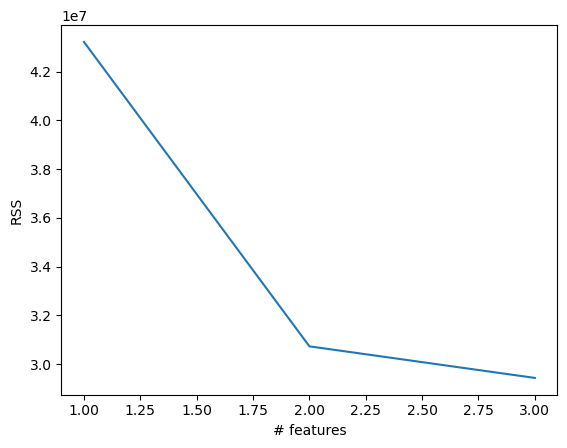

In [33]:
# plotting the RSS of best models with different number of parameters
plt.figure()
plt.plot(models["RSS"])
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()

In [35]:
print(models.loc[3, 'Model'].summary()) # the above plot showed me that I should maybe consider a model with 3 features as it has the lowest RSS

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.772
Model:                            OLS   Adj. R-squared (uncentered):              0.769
Method:                 Least Squares   F-statistic:                              292.7
Date:                Tue, 23 May 2023   Prob (F-statistic):                    5.01e-83
Time:                        11:04:05   Log-Likelihood:                         -1902.0
No. Observations:                 263   AIC:                                      3810.
Df Residuals:                     260   BIC:                                      3821.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [37]:
# find the adjusted R^2, use dir() to identify all available attributes
rsquared_adj = models.apply(lambda row: row[1].rsquared_adj, axis=1) 

#### Notes on interpretation:
- The code above creates a new variable called rsquared_adj to store the adjusted R-squared values.
- It applies a lambda function to each row of the models DataFrame using the apply method with axis=1, which indicates that the function should be applied row-wise.
- Within the lambda function, row[1] refers to the second column (index 1) of each row, which contains the model objects.
- It accesses the rsquared_adj attribute of each model object using .rsquared_adj.
- The calculated adjusted R-squared values are assigned to the rsquared_adj variable.

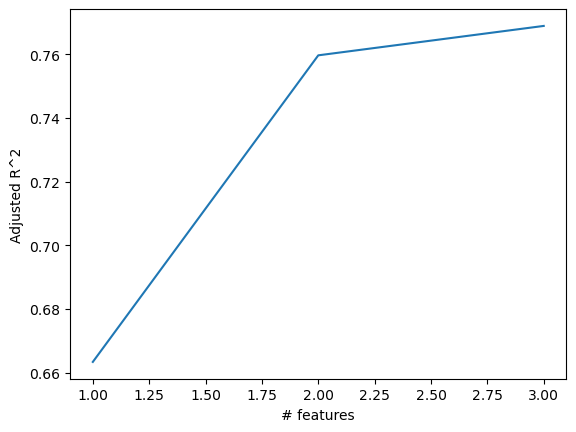

In [39]:
# plotting results of adjusted R^2
plt.figure()
plt.plot(rsquared_adj)
plt.xlabel('# features')
plt.ylabel('Adjusted R^2')
plt.show()

### 3. Stepwise feature selection

Stepwise feature selection includes different methods, most popular are forward / backward selection. In general, stepwise selection techniques start with an empty model and iteratively adds or removes features based on predefined criteria until a stopping condition is met. The goal is to find the most relevant features that contribute to the model's performance while controlling for model complexity.

### Forward stepwise selection

Forward selection is a stepwise feature selection method. It starts with an empty model and iteratively adds one feature at a time based on predefined criteria until a stopping condition is met. The goal is to identify the most relevant features that contribute to the model's performance.

<b>It may be best to use forward selection over other methods in the following circumstances:</b>
- When computational resources are limited: Forward selection starts with an empty model and iteratively adds one feature at a time. This stepwise approach is computationally efficient compared to best subset selection since it doesn't evaluate all feature combinations. If computational resources are limited, forward selection can be a practical choice.
- When dealing with a large number of features: Forward selection is particularly useful when the feature space is vast. By starting with an empty model and iteratively adding features, it can efficiently explore the feature space without having to evaluate all possible combinations.

In [40]:
# using RSS function defined in this notebook
# creating new function to do forward stepwise selection 

def forward_select(y, X, feature_list):
    remaining_predictors = [p for p in X.columns if p not in feature_list]
    results = []
    for p in remaining_predictors:
        results.append(getRSS(y, X, feature_list+[p]))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model  

In [41]:
# testing out the forward stepwise selection function

models2 = pd.DataFrame(columns=["RSS", "Model"]) # creates an empty DataFrame called models2 with two columns: "RSS" and "Model" to store the results of the forward selection process
feature_list = [] # initialises an empty list
for i in range(1,len(X.columns)+1):
    models2.loc[i] = forward_select(y, X, feature_list) # calls the forward_select function, passing y, X, and the current feature_list as arguments, to obtain the best model for the given number of features which is stored in 'models2'
    feature_list = models2.loc[i]["Model"].model.exog_names # feature_list is updated to include the features from the best model 

In [42]:
# comparing results of best subset selection vs the forward selection
print('Best max_feature variable from best subset selection on tranining')
print(models.loc[max_feature, 'Model'].params)
print('\n---------------------------------------------')
print('Best max_feature variable from forward selection on tranining')
print(models2.loc[max_feature, 'Model'].params)

Best max_feature variable from best subset selection on tranining
Hits       2.316407
CRBI       0.666517
PutOuts    0.261395
dtype: float64

---------------------------------------------
Best max_feature variable from forward selection on tranining
Hits       2.316407
CRBI       0.666517
PutOuts    0.261395
dtype: float64


### Backward elimination 

Backward elimination is a feature selection method that starts with a model containing all features and iteratively removes one feature at a time based on predefined criteria. It aims to identify the most relevant subset of features that contribute to the model's performance.

<b>It's best to use backward elimination in the following circumstances:</b>
- When dealing with a large number of features: Similar to forward selection, backward elimination is well-suited for scenarios with a large feature space. It starts with a model containing all features and iteratively removes one feature at a time. This method can help identify the most relevant features without exhaustively evaluating all feature combinations.
- When computational resources are limited: Backward elimination reduces the number of features over iterations, potentially making it less computationally demanding compared to best subset selection.

In [43]:
# doing very similar to forward stepwise selection function above, also using previously defined RSS function

def backward_select(y, X, feature_list):
    results = []
    for combo in itertools.combinations(feature_list, len(feature_list)-1): # loop iterates through all combinations of features obtained by using 'itertools.combinations'. The loop generates combinations of len(feature_list)-1 features from the feature_list.
        results.append(getRSS(y, X, combo)) # gets RSS for each combo

    models = pd.DataFrame(results) # RSS values for each combination of features are stored in a DataFrame called models
    best_model = models.loc[models['RSS'].idxmin()] #  selects the model with the minimum RSS from the models DataFrame and returns it as the best model
    return best_model 

In [44]:
# testing out backward stepwise selection function 

models3 = pd.DataFrame(columns=["RSS", "Model"], index = range(1,len(X.columns)))
feature_list = X.columns

while(len(feature_list) > 1):
    models3.loc[len(feature_list)-1] = backward_select(y, X, feature_list)
    feature_list = models3.loc[len(feature_list)-1]["Model"].model.exog_names

print(models3.loc[max_feature, "Model"].params)

Hits       2.111712
CRuns      0.646149
PutOuts    0.295625
dtype: float64


In [47]:
# comparison of all results from all three selection methods
print('Best 3 variable model from best subset selection on tranining')
print(models.loc[max_feature, 'Model'].params)
print('\n---------------------------------------------')
print('Best 3 variable model from forward selection on tranining')
print(models2.loc[max_feature, 'Model'].params)
print('\n---------------------------------------------')
print('Best 3 variable model from backward selection on tranining')
print(models3.loc[max_feature, 'Model'].params)

Best 3 variable model from best subset selection on tranining
Hits       2.316407
CRBI       0.666517
PutOuts    0.261395
dtype: float64

---------------------------------------------
Best 3 variable model from forward selection on tranining
Hits       2.316407
CRBI       0.666517
PutOuts    0.261395
dtype: float64

---------------------------------------------
Best 3 variable model from backward selection on tranining
Hits       2.111712
CRuns      0.646149
PutOuts    0.295625
dtype: float64


#### Notes on interpretation

- These results provide information about the predictors (variables) included in the best 3-variable models and their respective coefficients. The coefficients indicate the strength and direction of the relationship between each predictor and the target variable. Comparing the coefficients across the different selection approaches can provide insights into the consistency and importance of the selected predictors in predicting the target variable.
- The variables and coefficients in best subset and forward selection are exactly the same (Hits: 2.316407, CRBI: 0.666517, PutOuts: 0.261395)
- In the backward selection process, one variable was removed from the original set of features (CRBI), resulting in a different combination of predictors and their corresponding coefficients (Hits: 2.111712, CRuns: 0.646149, PutOuts: 0.295625)


<b>What conclusions should I make?</b>
- I can conclude that Hits and PutOuts are important variables in predicting the target variable, their coefficients are consistent too but including CBRI / excluding CRuns changes the value
- I could potentially try creating a 4 variable model which includes both CBRI and CRuns? 
- I could also rerun the best subset selection method to assess any variability in results
- Outside of the code, I could do more domain research to understand what these variables mean
- If I've got a lot of time, I could also assess the overall performance of the models generated by each feature selection method. Evaluate metrics such as R-squared, adjusted R-squared, or cross-validated performance to compare the predictive capability of the models. A more reliable method may lead to better-performing models.

### 4. Choosing models using the validation set approach and cross-validation
We've defined the 'best' models using various methods and statistics (mainly RSS and adjusted R^2, but we could've used other statistics like AIC and BIC too). However, we haven't tested the performance of these models. We may be at risk of selecting a model which is overfitting on it's training data. This section will use the validation set approach to select models whilst testing their performance on test data.

The validation set approach and cross-validation are techniques used to estimate the performance and evaluate the generalisation ability of predictive models. They involve splitting the available data into training and testing subsets, allowing the model to be trained on one subset and evaluated on another.


<b>Validation set approach:</b> Involves splitting data into two subsets: a training set and a validation set.
The training set is used to train the model, typically by fitting the parameters or learning the patterns in the data.
The validation set is used to assess the performance of the trained model. It helps estimate how well the model generalizes to unseen data. After training the model on the training set, it is evaluated on the validation set using appropriate evaluation metrics (e.g., accuracy, mean squared error). The performance on the validation set serves as an estimate of how the model is likely to perform on new, unseen data.
- <b>Advantages:</b> Straightforward and easy to implement.
- <b>Disadvantages:</b> May suffer from high variability and dependence on the specific split between training and validation sets.


<b>Cross-validation:</b> Resampling technique that addresses the limitations of the validation set approach by repeatedly splitting the data into training and testing subsets. Most common form of cross-validation is k-fold cross-validation, where the data is divided into k equal-sized folds. The model is trained and evaluated k times, each time using a different fold as the testing set and the remaining folds as the training set. Performance metrics are calculated for each fold, and the average performance across all folds is taken as the estimate of the model's generalization performance.
- <b>Advantages:</b> Reduces the dependency on a particular split of the data and provides a more robust estimate of the model's performance
- <b>Disadvantages:</b> Can be complicated and computationally expensive. 

### Validation set approach

In [48]:
# randomly splitting the data into training and validation datasets, selecting 70% of data for training, 30% for testing
np.random.seed(seed = 21)
train_index = np.random.choice([True, False], size = len(y), replace = True, p = [0.7, 0.3])

# creating new test / train dataframes for the response (Y) and variables (X)
test_index = np.invert(train_index)
X_train= X[train_index]
y_train = y[train_index]
X_test = X[test_index]
y_test = y[test_index]

In [50]:
# recycling old functions (above) but with modifications to include both test / train datasets

def getRSS_validation(y_train, X_train, y_test, X_test,  feature_list):
    model = sm.OLS(y_train, X_train[list(feature_list)]).fit() # fitting model to training data
    RSS = ((model.predict(X_test[list(feature_list)]) - y_test) ** 2).sum() # predicting results for test data, storing RSS values
    return {'Model':model, "RSS":RSS}

def bestModel_validation(y_train, X_train, y_test, X_test, K):
    results = []
    for c in itertools.combinations(X_train.columns, K):
        results.append(getRSS_validation(y_train, X_train, y_test, X_test, c)) # calls getRSS_validation function to peform model training, predictions, and RSS storing  
    model_all =  pd.DataFrame(results)
    best_model = model_all.loc[model_all["RSS"].idxmin()] 
    return best_model

def forward_select_validation(y_train, X_train, y_test, X_test,  feature_list):
    remaining_predictors = [p for p in X_train.columns if p not in feature_list] # considers the remaining predictors (not in the current feature_list) and iteratively adds one predictor at a time to the feature_list.
    results = []
    for p in remaining_predictors:
        results.append(getRSS_validation(y_train, X_train, y_test, X_test, feature_list+[p])) # again calls getRSS_validation function to peform model training, predictions, and RSS storing  
    model_all =  pd.DataFrame(results)
    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model

def backward_select_validation(y_train, X_train, y_test, X_test,  feature_list):
    results = []
    for combo in itertools.combinations(feature_list, len(feature_list)-1): # considers all combinations of the predictors in the current feature_list except one (one less predictor at a time)
        results.append(getRSS_validation(y_train, X_train, y_test, X_test,  combo)) # again calls getRSS_validation function to peform model training, predictions, and RSS storing  
    model_all =  pd.DataFrame(results)
    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model 

In [52]:
models_validation = pd.DataFrame(columns=["RSS", "Model"])
for i in range(1,(max_feature+1)):
    models_validation.loc[i] = bestModel_validation(y_train, X_train, y_test, X_test, i) 

In [54]:
print('Best 3-variable model from best subset selection on tranining')
print(models.loc[max_feature, 'Model'].params)
print('\n---------------------------------------------')
print('Best 3-variable model from forward selection on tranining')
print(models2.loc[max_feature, 'Model'].params)
print('\n---------------------------------------------')
print('Best 3-variable model from backward selection on tranining')
print(models3.loc[max_feature, 'Model'].params)
print('\n---------------------------------------------')
print('Best 3-variable model from best subset selection on traning and validation split')
print(models_validation.loc[max_feature, 'Model'].params)

Best 3-variable model from best subset selection on tranining
Hits       2.316407
CRBI       0.666517
PutOuts    0.261395
dtype: float64

---------------------------------------------
Best 3-variable model from forward selection on tranining
Hits       2.316407
CRBI       0.666517
PutOuts    0.261395
dtype: float64

---------------------------------------------
Best 3-variable model from backward selection on tranining
Hits       2.111712
CRuns      0.646149
PutOuts    0.295625
dtype: float64

---------------------------------------------
Best 3-variable model from best subset selection on traning and validation split
Hits       2.591880
CHmRun     2.675775
PutOuts    0.210471
dtype: float64


In [73]:
models2_forward = pd.DataFrame(columns=["RSS", "Model"])
feature_list = []
for i in range(1,len(X.columns)+1):
    models2_forward.loc[i] = forward_select_validation(y_train, X_train, y_test, X_test, feature_list)
    feature_list = models2_forward.loc[i]["Model"].model.exog_names    

models3_backward = pd.DataFrame(columns=["RSS", "Model"]) # see below, think there might be a problem with this?
feature_list = []
i = 1  # initialize i to 1
while len(feature_list) > 1:
    models3_backward.loc[i] = backward_select_validation(y_train, X_train, y_test, X_test, feature_list)
    feature_list = models3_backward.loc[i]["Model"].model.exog_names
    i += 1  # increment i after assigning values to models3_backward

In [72]:
print('Best 3-variable model from best subset selection on tranining')
print(models.loc[max_feature, 'Model'].params)
print('\n---------------------------------------------')
print('Best 3-variable model from forward selection on tranining')
print(models2.loc[max_feature, 'Model'].params)
print('\n---------------------------------------------')
print('Best 3-variable model from backward selection on tranining')
print(models3.loc[max_feature, 'Model'].params)
print('\n---------------------------------------------')
print('Best 3-variable model from best subset selection on traning and validation split')
print(models_validation.loc[max_feature, 'Model'].params)
print('\n---------------------------------------------')
print('Best 3-variable model from forward selection on traning and validation split')
print(models2_forward.loc[max_feature, 'Model'].params)
print('\n---------------------------------------------')

# tried adding in backward models but it didn't work?

Best 3-variable model from best subset selection on tranining
Hits       2.316407
CRBI       0.666517
PutOuts    0.261395
dtype: float64

---------------------------------------------
Best 3-variable model from forward selection on tranining
Hits       2.316407
CRBI       0.666517
PutOuts    0.261395
dtype: float64

---------------------------------------------
Best 3-variable model from backward selection on tranining
Hits       2.111712
CRuns      0.646149
PutOuts    0.295625
dtype: float64

---------------------------------------------
Best 3-variable model from best subset selection on traning and validation split
Hits       2.591880
CHmRun     2.675775
PutOuts    0.210471
dtype: float64

---------------------------------------------
Best 3-variable model from forward selection on traning and validation split
Hits       2.591880
CHmRun     2.675775
PutOuts    0.210471
dtype: float64

---------------------------------------------


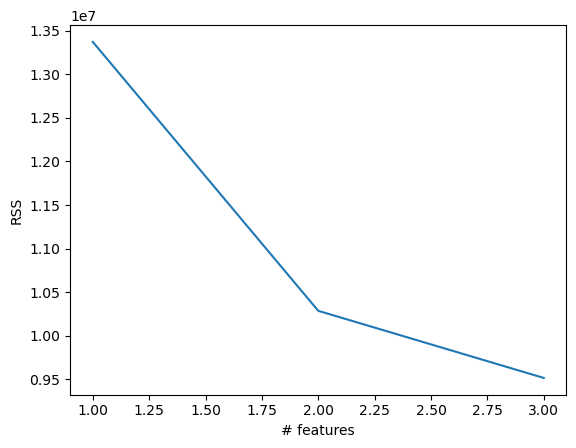

In [74]:
# plotting the RSS of best models with different number of parameters for best subset with validation
plt.figure()
plt.plot(models_validation["RSS"])
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()

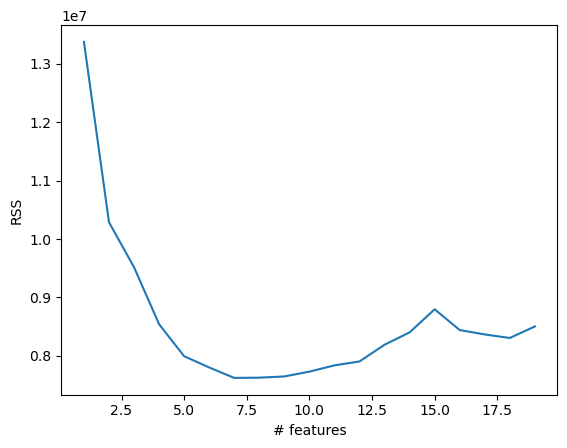

In [75]:
# plotting the RSS of best models with different number of parameters for forward selection with validation
plt.figure()
plt.plot(models2_forward["RSS"])
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()

#### Notes on interpretation
- Looks like a 7-variable model will perform best under forward stepwise selection
- We could go back and retrain the model with 7 variables instead of 3

### Cross-validation
Similar approach to previous block, difference is that we break the entire dataset into K different folds. On each run, the model will be trained on all the data from K-1 folds and tested on the remaining fold. 

In [79]:
k = 10
np.random.seed(seed=21)
train_index = np.random.choice(k, size=len(y), replace=True)  # randomly assigning observations into folds
cv_errors = pd.DataFrame(columns=range(1,k+1), index=range(1,len(X.columns) + 1))

In [80]:
# training and testing on each fold
models_cv = pd.DataFrame(columns=["RSS", "Model"])
for j in range(1,k+1):
    feature_list = []
    for i in range(1,len(X.columns)+1):
        models_cv.loc[i] = forward_select_validation(y[train_index != (j-1)], X[train_index != (j-1)], 
                                                     y[train_index == (j-1)],X[train_index == (j-1)], 
                                                     feature_list)
        
        cv_errors[j][i] = models_cv.loc[i]["RSS"]
        feature_list = models_cv.loc[i]["Model"].model.exog_names

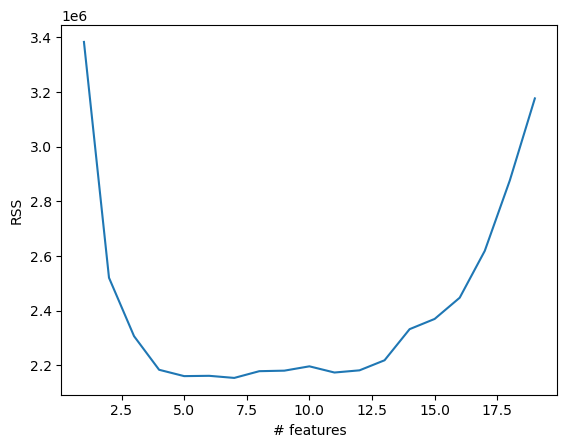

In [81]:
# plotting the performance of each model 
cv_errors_mean = cv_errors.mean(axis = 1)
plt.figure()
plt.plot(cv_errors_mean)
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()

In [83]:
# taking a closer look at the summary of the model with 5 features, given the plot shows it produces the lowest RRS
print(models_cv.loc[5, "Model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.771
Model:                            OLS   Adj. R-squared (uncentered):              0.766
Method:                 Least Squares   F-statistic:                              155.0
Date:                Tue, 23 May 2023   Prob (F-statistic):                    1.40e-71
Time:                        12:57:41   Log-Likelihood:                         -1704.1
No. Observations:                 235   AIC:                                      3418.
Df Residuals:                     230   BIC:                                      3435.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### 6. Regularisation methods

Regularisation methods are techniques to improve the generalization performance of models. They introduce additional constraints or penalties to the model's objective function, discouraging excessive complexity and reducing the impact of noisy or irrelevant features. Regularisation helps find a balance between fitting the training data well and avoiding overfitting, resulting in models that perform better on unseen data.

<b>Regularisation methods (e.g., L1 regularisation: LASSO, L2 regularisation: ridge regression) may be preferred in the following circumstances:</b>

- When dealing with high-dimensional data: Regularization methods are effective when the number of features is large compared to the number of samples. They apply a penalty term that shrinks the coefficients of less important features, effectively performing automatic feature selection and reducing overfitting.
- When dealing with multicollinearity: Regularization methods are robust to multicollinearity, which occurs when features are highly correlated. They can handle situations where features are interrelated by shrinking their coefficients and selecting the most informative ones.
- When a balance between simplicity and predictive performance is desired: Regularization methods strike a balance between model simplicity and predictive performance. They can help prevent overfitting by imposing a penalty on the complexity of the model, making them suitable when you want to avoid overly complex models.

### Ridge regression

Ridge regression, also known as Tikhonov regularisation, is a linear regression technique that addresses the problem of multicollinearity (high correlation among predictor variables) and overfitting in the ordinary least squares (OLS) regression. It introduces a regularisation term to the loss function, which helps stabilise and improve the performance of the model.

In ridge regression, the goal is to minimize the sum of squared errors between the predicted values and the actual values, similar to OLS regression. However, ridge regression adds a penalty term that is proportional to the square of the magnitude of the regression coefficients. This penalty term encourages the coefficients to be smaller, reducing their impact on the model's output.

In ridge regression, the regularisation parameter (alpha) controls the strength of the penalty term. It determines the trade-off between fitting the data well and keeping the coefficients small. A higher value of alpha results in more shrinkage of the coefficients, effectively reducing their impact on the model.

<b>Key characteristics and benefits of ridge regression include:</b>

Shrinking coefficients: Ridge regression shrinks the regression coefficients towards zero, but does not set them exactly to zero (unless α is extremely high). This makes ridge regression suitable for situations where all variables may be relevant to some extent.

Multicollinearity handling: Ridge regression is particularly effective in handling multicollinearity, where predictor variables are highly correlated. By reducing the impact of correlated variables, it helps stabilize the model and improves its performance.

Bias-variance trade-off: Ridge regression balances the trade-off between bias and variance. It reduces the variance of the model by shrinking the coefficients, but introduces a slight bias due to the penalty term. This can lead to better predictive performance on unseen data compared to OLS regression.

Regularization path: Ridge regression provides a regularization path, allowing the effect of different values of α to be observed on the coefficients. This can help in selecting an optimal value of α through cross-validation or other model selection techniques.

In [84]:
alphas = 10**np.linspace(10,-2,100)
print(alphas)

[1.00000000e+10 7.56463328e+09 5.72236766e+09 4.32876128e+09
 3.27454916e+09 2.47707636e+09 1.87381742e+09 1.41747416e+09
 1.07226722e+09 8.11130831e+08 6.13590727e+08 4.64158883e+08
 3.51119173e+08 2.65608778e+08 2.00923300e+08 1.51991108e+08
 1.14975700e+08 8.69749003e+07 6.57933225e+07 4.97702356e+07
 3.76493581e+07 2.84803587e+07 2.15443469e+07 1.62975083e+07
 1.23284674e+07 9.32603347e+06 7.05480231e+06 5.33669923e+06
 4.03701726e+06 3.05385551e+06 2.31012970e+06 1.74752840e+06
 1.32194115e+06 1.00000000e+06 7.56463328e+05 5.72236766e+05
 4.32876128e+05 3.27454916e+05 2.47707636e+05 1.87381742e+05
 1.41747416e+05 1.07226722e+05 8.11130831e+04 6.13590727e+04
 4.64158883e+04 3.51119173e+04 2.65608778e+04 2.00923300e+04
 1.51991108e+04 1.14975700e+04 8.69749003e+03 6.57933225e+03
 4.97702356e+03 3.76493581e+03 2.84803587e+03 2.15443469e+03
 1.62975083e+03 1.23284674e+03 9.32603347e+02 7.05480231e+02
 5.33669923e+02 4.03701726e+02 3.05385551e+02 2.31012970e+02
 1.74752840e+02 1.321941

<b> Notes on interpretation </b>

The code <code>alphas = 10**np.linspace(10,-2,100)</code> generates an array of alpha values that will be used for this ridge regression. Specifically, it creates an array of 100 values evenly spaced between 10 and -2. It then applies a power of 10 to each value in the array. The resulting array will contain 100 alpha values ranging from 10^10 to 10^-2.

By generating a range of alpha values in this way, you can explore a wide range of regularisation strengths during ridge regression. The alpha values will be used to fit and evaluate ridge regression models with different levels of regularisation, allowing you to find the optimal alpha that balances model complexity and performance.

In [89]:
ridge = Ridge(fit_intercept=True) # initialises a Ridge regression model. The 'fit_intercept=True' parameter indicates that an intercept term should be included in the model, and normalize=True specifies that the features should be normalized before fitting the model.
coeffs = []
intercepts = []
# ^ empty lists will be used to store the coefficients and intercepts obtained from ridge regression for each alpha value

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
# ^ normalising the features before fitting the model

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X, y)
    coeffs.append(ridge.coef_)
    intercepts.append(ridge.intercept_)

#### Notes on interpretation
By looping over the range of alpha values, the code performs ridge regression multiple times, each time with a different level of regularization. It collects the coefficients and intercepts obtained from each ridge regression model and stores them in the coeffs and intercepts lists, respectively. This allows you to examine how the coefficients and intercept change as the regularization strength (alpha) varies.

In [90]:
print(len(coeffs))
print(len(coeffs[0]))
print(len(intercepts))
print(intercepts[0])

100
19
100
498.29708183837045


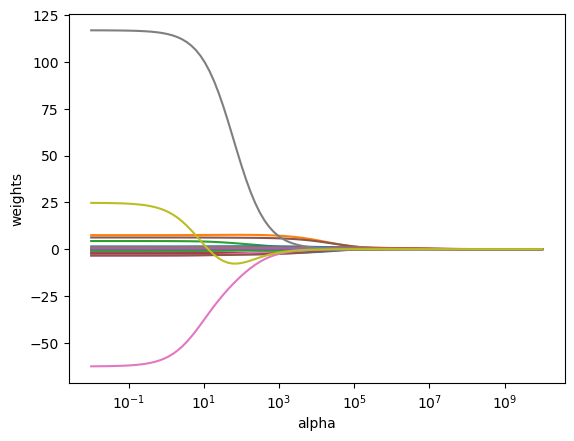

In [92]:
# plotting how the weights (coefficients) change as the regularization parameter alpha varies. 

ax = plt.gca() # getting the current axes instance
ax.plot(alphas, coeffs) # plotting the coefficients (coeffs) against the alpha values (alphas). Each line in the plot represents the coefficients for a specific feature
ax.set_xscale('log') # setting  the x-axis scale to logarithmic. This is commonly done when plotting alpha values in ridge regression since the alpha values usually span a wide range.
plt.axis('tight') # adjusting the axis limits to fit the data tightly.
plt.xlabel('alpha')
plt.ylabel('weights')
plt.show()

In [94]:
# looking at an example
sample = 49
print(alphas[sample])
print(math.sqrt(sum(map(lambda x:x*x, coeffs[sample]))))
print(coeffs[sample])

11497.569953977356
6.715562738164365
[-1.45023602  4.5954725  -0.13653202  0.5127596   0.55286948  4.08151178
 -0.02954628 -0.27034404  0.55217839  0.18239527  1.16659294  0.64526686
 -0.51646782  0.29365016  0.32321952 -1.21748578 -0.24313669  0.64184912
 -0.1761547 ]


In [96]:
# splitting data into test / train sets in order to estimate test error for ridge regression
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.66) # using Python built-in function

In [97]:
# training model and creating predictions from test dataset 
ridge = Ridge(fit_intercept=True, alpha=4)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
ridge.fit(X_train, y_train) # fitting a ridge regression on the training data
pred = ridge.predict(X_test) # using model to predict the test data
print(pd.Series(ridge.coef_, index=X.columns)) 
print(mean_squared_error(y_test, pred))        

AtBat          -0.490220
Hits            3.321209
HmRun           7.159825
Runs            2.835042
RBI            -3.503921
Walks          -1.779500
Years          14.381681
CAtBat         -0.631908
CHits           2.179848
CHmRun          0.601805
CRuns          -0.564495
CRBI            0.582052
CWalks          0.827004
PutOuts         0.337649
Assists         0.196889
Errors         -2.321242
League_A      -47.917668
Division_E     -0.733416
NewLeague_A    28.322887
dtype: float64
132956.76478350602


In [109]:
# not sure what this is doing or if it is right? 

# using CV to select best alpha value. Reporting on test set performance as the final performance metric  
ridgecv =  RidgeCV(alphas, scoring='neg_mean_squared_error')
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

1321941.1484660287

In [108]:
# not sure what this is doing or if it is right? 

# producing the mean squred error of the selected alpha on test dataset
ridge_best = Ridge(alpha=ridgecv.alpha_)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
ridge_best.fit(X_train, y_train)
mean_squared_error(y_test, ridge_best.predict(X_test))

132922.0231444014

In [107]:
# examining values of coefficients (a lot will be tiny but not 0)
pd.Series(ridge_best.coef_, index=X.columns)

AtBat          0.353450
Hits           0.176878
HmRun          0.025462
Runs           0.105949
RBI            0.071410
Walks          0.035664
Years         -0.001023
CAtBat        -0.040497
CHits          0.229018
CHmRun         0.067474
CRuns          0.171831
CRBI           0.198386
CWalks         0.082843
PutOuts        0.385379
Assists       -0.078019
Errors        -0.008235
League_A       0.000173
Division_E     0.000754
NewLeague_A    0.000802
dtype: float64

### LASSO

Adds a penalty term to the objective function proportional to the absolute value of the regression coefficients. The LASSO regularisation term encourages sparsity in the model by driving some of the coefficients to exactly zero. This leads to feature selection, as irrelevant features are effectively excluded from the model. LASSO is particularly useful when dealing with high-dimensional datasets where only a subset of features is expected to be relevant.

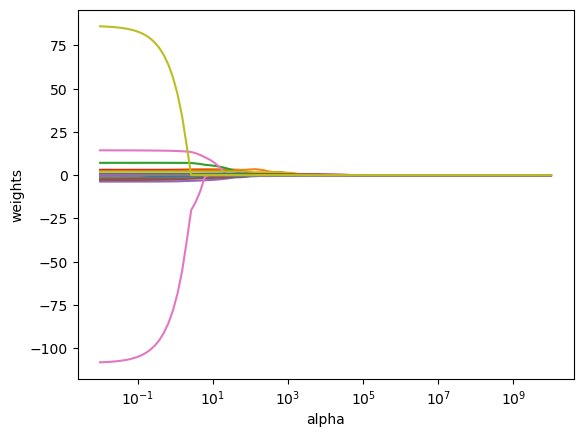

137193.87990711155

In [122]:
lasso= Lasso(max_iter=100000) 
coeffs = []

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coeffs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas, coeffs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.show()

lassocv = LassoCV(alphas=None, cv=10, max_iter=100000)
lassocv.fit(X_train, y_train)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))

In [123]:
# checking that some of the coefficients have reduced to 0
pd.Series(lasso.coef_, index=X.columns)

AtBat          0.450411
Hits           0.000000
HmRun          0.000000
Runs           0.000000
RBI            0.000000
Walks          0.000000
Years         -0.000000
CAtBat         0.000000
CHits          0.197706
CHmRun         0.000000
CRuns          0.000000
CRBI           0.191474
CWalks         0.000000
PutOuts        0.405333
Assists       -0.000000
Errors        -0.000000
League_A       0.000000
Division_E     0.000000
NewLeague_A    0.000000
dtype: float64

### 8. Principal component regression
Principal Component Regression (PCR) is a regression technique that combines Principal Component Analysis (PCA) with linear regression. It is used when dealing with datasets that have a high number of correlated predictor variables and aims to address multicollinearity issues that can affect the performance and interpretability of linear regression models.

<b>The steps involved in PCR include:</b>

- Principal Component Analysis (PCA): PCA is applied to the predictor variables to transform them into a new set of uncorrelated variables called principal components. Each principal component is a linear combination of the original variables and represents a different direction or axis in the data space.

- Dimensionality reduction: In PCR, the number of principal components retained is typically lower than the total number of original variables. This dimensionality reduction helps capture most of the variance in the data while reducing multicollinearity.

- Linear regression on principal components: The principal components are then used as the predictors in a linear regression model. The dependent variable is regressed against these transformed predictors.

- Model estimation and interpretation: The linear regression model is estimated using techniques such as ordinary least squares (OLS). The coefficients obtained in the regression model represent the relationship between the dependent variable and the principal components, rather than the original predictor variables.



In [141]:
def pcr(X,y,pc): 
    # initialising a PCA (Principal Component Analysis) object
    pca = PCA() 
    # applying PCA to the scaled input data (scale(X)) and performs dimensionality reduction by keeping only the first pc principal components
    X_pca = pca.fit_transform(scale(X))[:,:pc]
    # creating linear regression object
    regr = linear_model.LinearRegression()
    # fitting the linear regression model to the transformed data (X_pca) and the target variable (y). It finds the optimal coefficients that represent the linear relationship between the principal components and the target variable.
    regr.fit(X_pca, y)
    # predicting the target variable (y) using the trained linear regression model and the transformed data (X_pca)
    y_train = regr.predict(X_pca)
    # performing cross-validation using the linear regression model and the transformed data
    y_cv = cross_val_predict(regr, X_pca, y, cv=20)
    # calculating the coefficient of determination (R-squared) between the actual target values (y) and the predicted values for the training data (y_train)
    score_train = r2_score(y, y_train)
    # calculating R-squared between the actual target values (y) and the predicted values obtained from cross-validation (y_cv).
    score_cv = r2_score(y, y_cv) 
    # calculating the mean squared error between the actual target values (y) and the predicted values for the training data (y_train)
    mse_train = mean_squared_error(y, y_train) 
    # calculating the mean squared error between the actual target values (y) and the predicted values obtained from cross-validation (y_cv).
    mse_cv = mean_squared_error(y, y_cv)
    # returning a tuple of the items shown
    return(y_cv, score_train, score_cv, mse_train, mse_cv)

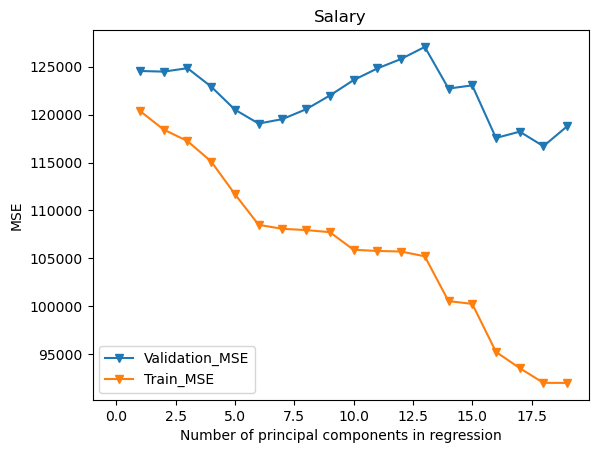

In [130]:
mse_train = []
mse_cv = []

# calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    results =  pcr(X,y,i)
    mse_train.append(results[3])
    mse_cv.append(results[4])
    
# plot results    
plt.plot(np.arange(1, 20), mse_cv, '-v', label = 'Validation_MSE')
plt.plot(np.arange(1, 20), mse_train, '-v', label = 'Train_MSE')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(left=-1)
plt.legend()
plt.show()

In [131]:
# Moving forward with 6 PCs

pcs = 6
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.66)

pca2 = PCA()
# scale the data
X_reduced_train = pca2.fit_transform(scale(X_train))
X_reduced_test = pca2.transform(scale(X_test))[:,:pcs]
# train regression model on training data 
regr = linear_model.LinearRegression()
regr.fit(X_reduced_train[:,:6], y_train)
# prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

126388.68808584691

In [132]:
np.cumsum(pca.explained_variance_ratio_) * 100

array([ 38.31423957,  60.15531541,  70.8416746 ,  79.03419435,
        84.29027516,  88.63477938,  92.26288766,  94.96304322,
        96.28269124,  97.25541298,  97.97775424,  98.64870031,
        99.15178693,  99.4730334 ,  99.74659124,  99.89398793,
        99.96815949,  99.99375108, 100.        ])

### 9. Partial least squares regression
Scikit-learn has function PLSRegression for partial least squares regression. PLSRegression is a technique for linear regression that is particularly useful for dealing with multicollinearity and high-dimensional data.

Despite the built-in function, we still need to write a few line of code to do the cross validation. The logic is same as before.

In [136]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.66)
pls = PLSRegression(n_components=2) #  initializes a PLSRegression model with n_components=2. 
pls.fit(scale(X_train), y_train) # line fits the PLSRegression model to the training data. The fit method trains the model by finding the optimal linear relationship between the scaled independent variables (scale(X_train)) and the dependent variable (y_train).

mean_squared_error(y_test, pls.predict(scale(X_test))) #  calculates the MSE between the actual target values (y_test) and the predicted target values obtained from the PLSRegression model 

153023.87101730768